In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline

In [2]:
'''
Wczytywanie pliku tekstowego do DataFrame
filename - nazwa pliku do wczytanie
head - rząd w którym zaczynamy zczytywać dane (licząc od 0), pierwszy rząd to nazwa kolumn w tworzonym DataFrame
'''
def read_file(filename = 'data/zofia_jogurt_kalib_2.txt', head = 8):
    df = pd.read_csv(filename, sep = '\t', header=head, index_col=0)
    try:
        df = df.drop(columns= ['Mic'])
    except KeyError as e:
        pass
    return df

In [3]:
'''
Wyznaczenie punktów do kalibracji
df - dataframe ze współrzędnymi X i Y z EyeTrackera
parts - określa na ile części dzielimy przedział czasowy
first_part - parametr określający ile części przedziału czasowego patrzono na pierwszy punkt
gap - parametr określający ile części przedziału czasowego zajął każdy pomiar
'''
def calc_points(df, parts = 6, first_part = 0.9, gap = 1):
    mid1 = df.iloc[:int(len(df)/parts * first_part), :]
    mid2 = df.iloc[int(len(df)/parts * (first_part + gap * 4 + 0.2)) :, :]
    lgora = df.iloc[int(len(df)/parts * (first_part + 0.2)) : int(len(df)/parts * (first_part + gap)), :]
    pgora = df.iloc[int(len(df)/parts * (first_part + gap + 0.2)) : int(len(df)/parts * (first_part + gap * 2)), :]
    ldol = df.iloc[int(len(df)/parts * (first_part + gap * 2 + 0.2)) : int(len(df)/parts * (first_part + gap * 3)), :]
    pdol = df.iloc[int(len(df)/parts * (first_part + gap * 3 + 0.2)) : int(len(df)/parts * (first_part + gap * 4)), :]

    #DataFrame ze średnimi wartościami dla punktu środkowego (średnia z początku i końca kalibracj)
    mid = mid1.mode().append(mid2.mode()).mean().astype('int')
    #tworzymy DataFrame z punktami do kalibracji (w kolejności: 0 - lewa góra, 1 - prawa góra, 2 - lewy dół, 3 - prawy dół, 4 - środek)
    points = lgora.mode().head(1).append(pgora.mode().head(1)).append(ldol.mode().head(1)).append(pdol.mode().head(1)).append(mid, ignore_index=True) 
    return points

In [4]:
'''
Funkcja rysuje wykres z danych otrzymanych w df (DataFrame), 
na którym znajdują się punkty oznaczające zapisane ruchy gałkek ocznych
oraz wyznaczone punkty kalibracji (czerwone krzyżyki).

Funkcja przyjmuje:
df - DataFrame z danymi do rysowania
filename - nazwa pliku do zapisu wykresu

Funkcja zapisuje wykres w pliku o nazwie "<filename>.png"
'''
def draw_calib_points(df, filename):
    new_filename = filename.split('.')[0] + '.png'
    Eye_X, Eye_Y = (df).Eye_X, (df).Eye_Y
    plt.clf()
    plt.plot(Eye_X, Eye_Y,"o",markersize=1)
    plt.grid(True)
    plt.xlabel('eye tracker x', fontsize=14)
    plt.ylabel('eye tracker y', fontsize=14)
    plt.title('punkty kalibracyjne', fontsize=16)
    plt.plot(points.Eye_X, points.Eye_Y,"+r",markersize=20)
    plt.savefig(new_filename)


In [5]:
'''
Funkcja przekazywana do curve_fit,
fitowanie wielu zmiennych
'''
def fit(X, a, b, c):
    x, y = X
    return a * x + b * y + c


'''
Funkcja rysuje wykres z dopasowaniem prostej do punktów kalibracyjnych.

Funkcja przyjmuje:
df - DataFrame z punktami wykorzystywanymi do kalibracji i odpowiadającymi im wartościami pikseli monitora
a i b - parametry dopasowywanej funkcji liniowej
minumum i maximum - minimum i maximum danych z EyeTrackera (wykorzystywane do policzenia skrajnych wartości na osi X)
filename - nazwa pliku do zapisu wykresu

Funkcja zapisuje wykres w pliku o nazwie "<filename>_liniowa_<nazwa osi>.png"
'''
def draw_calib_linear(df , a, b, c, minimum_x, maximum_x, minimum_y, maximum_y, filename, os):
    xfit = np.linspace(minimum_x-100, maximum_x+100, 2000, endpoint=True)
    yfit = np.linspace(minimum_y-100, maximum_y+100, 2000, endpoint=True)
    #zfit = np.array( fit((xfit, yfit), a, b, c), fit((yfit, xfit), ay, by, cy) )
    #fit((yfit, xfit), ay, by, cy)

    plt.clf()
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    X, Y = np.meshgrid(xfit, yfit)
    if os == 'X':
        ax.scatter(df.Eye_X, df.Eye_Y, df.x, marker = 'o', s=200, c='#00C900')
        Z =fit((X, Y), a, b, c)
        ax.set_zlabel("monitor x", fontsize=14)
    if os == 'Y':
       # plt.plot(df.Eye_Y, df.y,"+r",markersize=20)
        ax.scatter(df.Eye_X, df.Eye_Y, df.y, marker = 'o', s=200, c='#00C900')
        Z =fit((Y, X), a, b, c)
        ax.set_zlabel("monitor y", fontsize=14)
    ax.set_title('kalibracja liniowa dla dwóch zmiennych', fontsize=16)
    ax.set_xlabel("eye tracker x", fontsize=14)
    ax.set_ylabel("eye tracker y", fontsize=14)
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha=0.7)
    plt.grid(True)
        
    new_filename = filename.split('.')[0] + '_liniowa_' + os + '.png'
    plt.savefig(new_filename)


'''
Funkcja rysuje punkty po kalibracji, oznaczające obszar skupienia wzroku na monitorze.

Funkcja przyjmuje:
df - DataFrame z punktami do wyrysowania po kalibracji
filename - nazwa pliku do zapisu wykresu
przedzial - lista punktow oznaczajacych poczatek i koniec rejestracji sygnalu

Funkcja zapisuje wykres w pliku o nazwie "<filename>.png"
''' 
def draw_calibrated(df, filename, przedzial=None):
    if przedzial == None:
        przedzial = [20000, 80000]
    new_filename = filename.split('.')[0] + '.png'
    Eye_X, Eye_Y = df[przedzial[0] : przedzial[1]].Eye_X, df[przedzial[0] : przedzial[1]].Eye_Y
    #Eye_X, Eye_Y = df2.Eye_X, df2.Eye_Y * -1
    plt.clf()
    plt.plot(Eye_X, Eye_Y,"o",markersize=1)
    plt.xlabel('rzeczywiste x', fontsize=14)
    plt.ylabel('rzeczywiste y', fontsize=14)
    plt.title('wyniki po kalibracji', fontsize=16)
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.savefig(new_filename)

    

'''
Funkcja oblicza parametry kalibracji liniowej
oraz wykorzystując funkcje draw_calib_linear wyrysowuje i zapisuje wykresy z dopasowanymi prostymi do punktów kalibracyjnych. 

Funkcja przyjmuje;
points - DataFrame zawierający punkty wykorzystywane do klaibracji
filename - naz

Zwraca parametry jako tuple:
ax, bx, ay, by - pierwsze dwa to parametry kalibracji do osi X, pozostałe 2 to parametry kalibracji do osi Y
'''
def get_calibration_params(points, filename):
    #Do punktów kalibracyjnych dodajemy spodziewane wartości pikseli na ekranie monitora
    df_pixels = points.copy()
    df_pixels['x'] = pd.Series([0, 1280, 0, 1280, 640])
    df_pixels['y'] = pd.Series([32, 32, 992, 992, 496])
    
    #Obliczenie parametrów funkcji liniowej dla składowej x
    xdata_fit = (np.array(df_pixels.Eye_X), np.array(df_pixels.Eye_Y))
    ydata_fit = np.array(df_pixels.x)
    popt, pcov = curve_fit(fit, xdata_fit, ydata_fit)

    ax, bx, cx = popt
    
    #Obliczenie parametrów funkcji liniowej dla składowej y
    xdata_fit = (np.array(df_pixels.Eye_Y), np.array(df_pixels.Eye_X))
    ydata_fit = np.array(df_pixels.y)
    popt, pcov = curve_fit(fit, xdata_fit, ydata_fit)

    ay, by, cy = popt
    
    #Wyroysowanie dopasowania na wykresie:
    draw_calib_linear(df_pixels, ax, bx, cx, min(df_pixels.Eye_X),  max(df_pixels.Eye_X), min(df_pixels.Eye_Y),  max(df_pixels.Eye_Y), filename, 'X')
    draw_calib_linear(df_pixels, ay, by, cy, min(df_pixels.Eye_X),  max(df_pixels.Eye_X), min(df_pixels.Eye_Y),  max(df_pixels.Eye_Y), filename, 'Y')

    return ax, bx, cx, ay, by, cy

'''
Funkcja kalibruje zestaw otrzymanych danych w formacie DataFrame,
otrzymujemy zestaw danych który pokazuje gdzie patrzyła badana osoba na monitorze.

Funkcja przyjmuje:
df - DataFrame z danymi pomiarowymi z EyeTrackera do kalibracji
params_tuple = tuple z parametrami dopasowanych funkcji liniowych dla osi X i Y

Funkcja zwraca DataFrame z danymi pomiarowymi po kalibracji
'''
def calibrate_file(df, params_tuple):
    ax, bx, cx, ay, by, cy = params_tuple
    return df * [ax, ay] + [bx*df.Eye_Y, by*df.Eye_X] + [cx, cy]


    Eye_X  Eye_Y
0  1625.0   2725
1  2539.0   2600
2  1599.0   2431
3  2703.0   2100
4  2106.0   2474


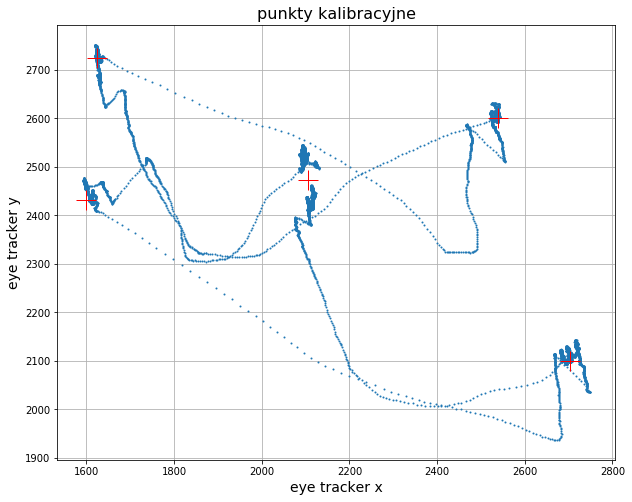

In [28]:
#Wczytanie pliku z danymi do kalibracji
fname = 'data/wojtek_30_04_kalib_2.txt'
df = read_file(filename=fname)

#Wyznaczanie punktów do kalibracji
points = calc_points(df)
plt.rcParams['figure.figsize'] = [10, 8]
print(points)

#Wyrysowanie i zapisanie wykresu z punktami pomiarowymi w czasie przeprowadzania kalibraci
#oraz z zaznoczonymi punktami, które zostaną wykorzystane do kalibracji.
fname = 'output/' + fname.split('/')[1]
draw_calib_points(df, fname)

(1.324777924625893, 0.28278155338571076, -2858.4497544867495, -2.4103521559880106, -0.5600499630200766, 7636.898058476085)


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

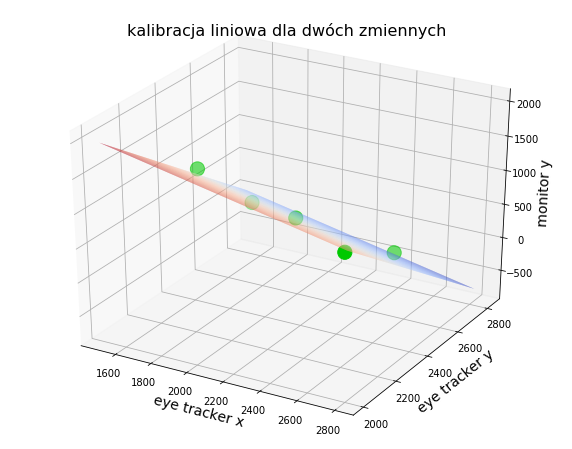

In [7]:
#Obliczanie parametrów funkcji kalibrującej
#oraz iyrysowanie i zapisanie wykresów z dopasowaniem funkcji kalibrującej
fname = 'output/' + fname.split('/')[1]
params = get_calibration_params(points, fname)
print(params)

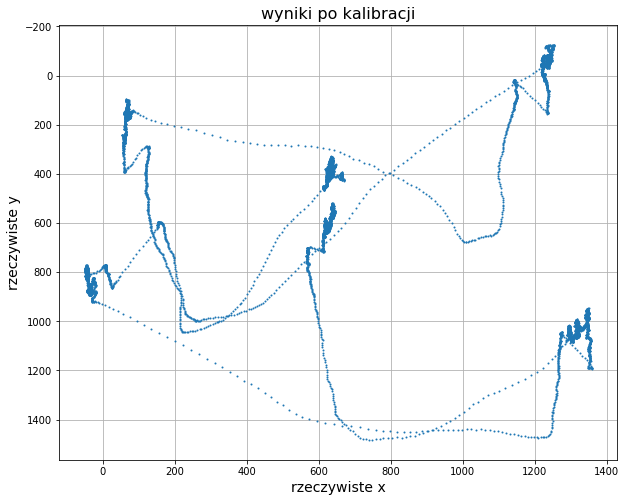

In [8]:
#Wczytanie pliku do kalibrowania (Właściwy plik pomiarowy z przeprowadzonego badania)
fname = 'data/wojtek_30_04_kalib_2.txt'
df = read_file(filename=fname)

#Kalibracja danych pomiarowych otrzymanych w eksperymencie
df2 = calibrate_file(df, params)

#Wyrysowanie i zapisanie wykresu z danymi pomiarowymi po kalibracji
#Dane pomiarowe mogą być z pewnogo przedziały czasowego badania
fname = 'output/' + fname.split('/')[1]
draw_calibrated(df2, fname, przedzial = [0, -1])

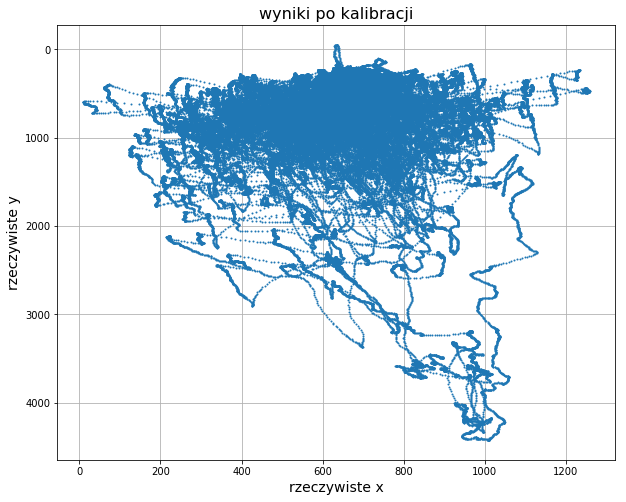

In [9]:
#Wczytanie pliku do kalibrowania (Właściwy plik pomiarowy z przeprowadzonego badania)
fname = 'data/wojtek_film_30_04.txt'
df = read_file(filename=fname)

#Kalibracja danych pomiarowych otrzymanych w eksperymencie
df2 = calibrate_file(df, params)

#Wyrysowanie i zapisanie wykresu z danymi pomiarowymi po kalibracji
#Dane pomiarowe mogą być z pewnogo przedziały czasowego badania
fname = 'output/' + fname.split('/')[1]
draw_calibrated(df2, fname, przedzial = [0, -1])

In [10]:
df2.to_csv('wojtek_film_30_04.txt', sep='\t')

    Eye_X  Eye_Y
0   814.0   1325
1  1295.0   1461
2   657.0   2089
3  1399.0   2223
4  1032.0   1911


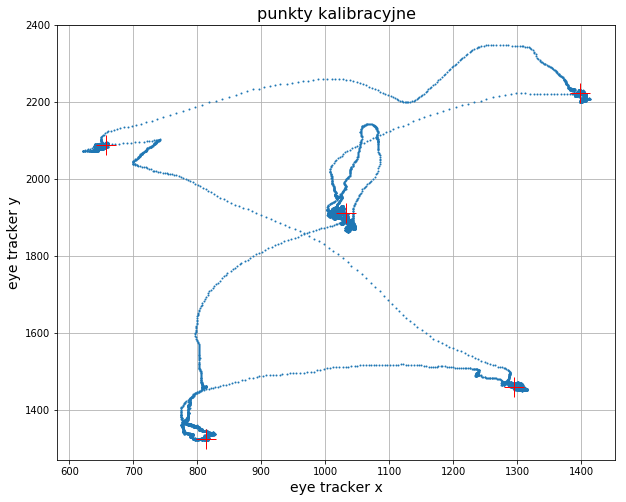

In [29]:
#Wczytanie pliku z danymi do kalibracji
fname = 'data/zofia_jogurt_kalib_2.txt'
df = read_file(filename=fname)

#Wyznaczanie punktów do kalibracji
points = calc_points(df)
plt.rcParams['figure.figsize'] = [10, 8]
print(points)

#Wyrysowanie i zapisanie wykresu z punktami pomiarowymi w czasie przeprowadzania kalibraci
#oraz z zaznoczonymi punktami, które zostaną wykorzystane do kalibracji.
fname = 'output/' + fname.split('/')[1]
draw_calib_points(df, fname)

(1.9850634290107072, 0.08342131950016285, -1573.5834615939248, 1.2128733090074777, -0.2541020997841197, -1412.4414056591484)


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

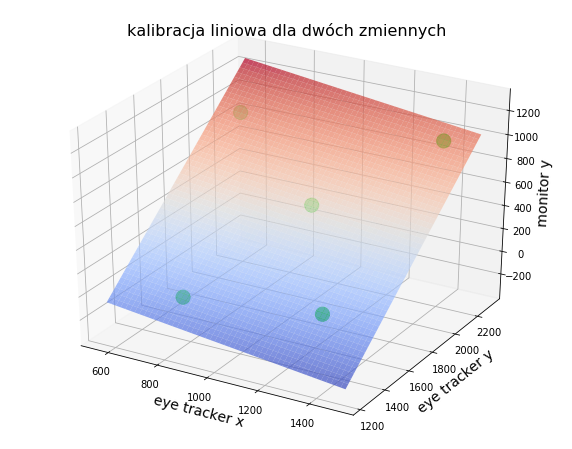

In [12]:
#Obliczanie parametrów funkcji kalibrującej
#oraz iyrysowanie i zapisanie wykresów z dopasowaniem funkcji kalibrującej
fname = 'output/' + fname.split('/')[1]
params = get_calibration_params(points, fname)
print(params)

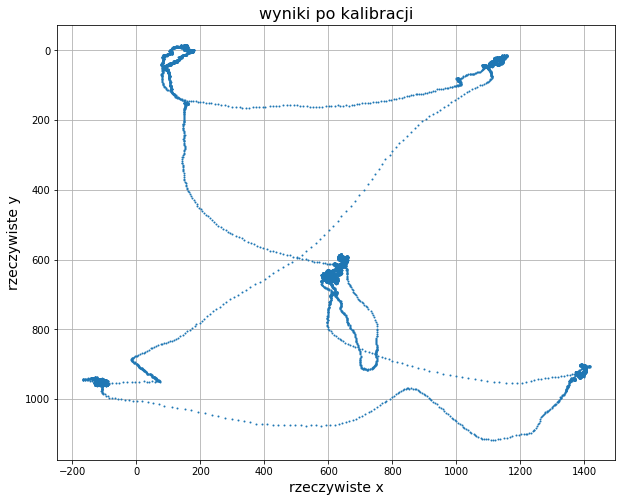

In [13]:
#Wczytanie pliku do kalibrowania (Właściwy plik pomiarowy z przeprowadzonego badania)
fname = 'data/zofia_jogurt_kalib_2.txt'
df = read_file(filename=fname)

#Kalibracja danych pomiarowych otrzymanych w eksperymencie
df2 = calibrate_file(df, params)

#Wyrysowanie i zapisanie wykresu z danymi pomiarowymi po kalibracji
#Dane pomiarowe mogą być z pewnogo przedziały czasowego badania
fname = 'output/' + fname.split('/')[1]
draw_calibrated(df2, fname, przedzial = [0, -1])

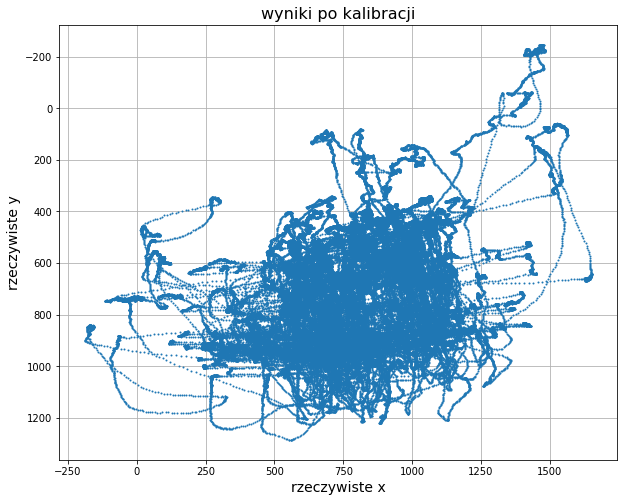

In [14]:
#Wczytanie pliku do kalibrowania (Właściwy plik pomiarowy z przeprowadzonego badania)
fname = 'data/zofia_jogurt.txt'
df = read_file(filename=fname)

#Kalibracja danych pomiarowych otrzymanych w eksperymencie
df2 = calibrate_file(df, params)

#Wyrysowanie i zapisanie wykresu z danymi pomiarowymi po kalibracji
#Dane pomiarowe mogą być z pewnogo przedziały czasowego badania
fname = 'output/' + fname.split('/')[1]
draw_calibrated(df2, fname, przedzial = [0, -1])

In [15]:
df2.to_csv('zofia_jogurt.txt', sep='\t')

   Eye_X  Eye_Y
0    754   2148
1   1352   2135
2    780   2440
3   1335   2413
4   1083   2344


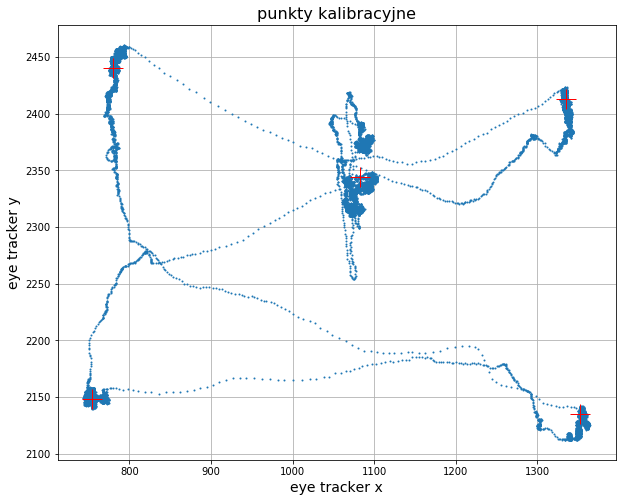

In [30]:
#Wczytanie pliku z danymi do kalibracji
fname = 'data/kalib_wojtek.txt'
df = read_file(filename=fname, head=9)

#Wyznaczanie punktów do kalibracji
points = calc_points(df)
plt.rcParams['figure.figsize'] = [10, 8]
print(points)

#Wyrysowanie i zapisanie wykresu z punktami pomiarowymi w czasie przeprowadzania kalibraci
#oraz z zaznoczonymi punktami, które zostaną wykorzystane do kalibracji.
fname = 'output/' + fname.split('/')[1]
draw_calib_points(df, fname)

(2.2110464471030715, -0.07356456100672903, -1536.573839021416, 3.2367711985258607, 0.09697112603832403, -7025.693642323045)


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

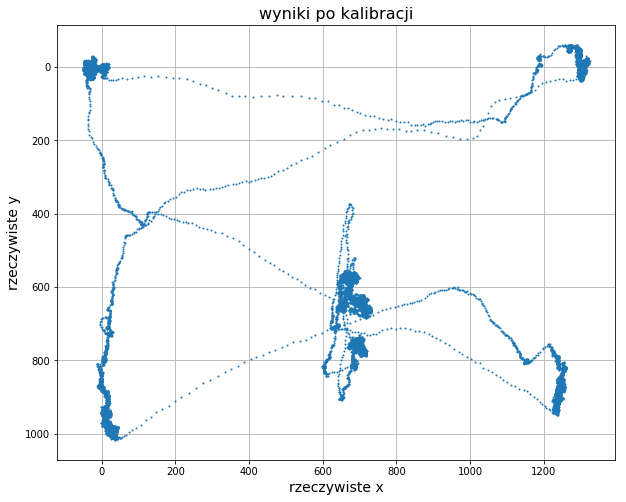

In [17]:
#Obliczanie parametrów funkcji kalibrującej
#oraz iyrysowanie i zapisanie wykresów z dopasowaniem funkcji kalibrującej
fname = 'output/' + fname.split('/')[1]
params = get_calibration_params(points, fname)
print(params)

#Wczytanie pliku do kalibrowania (Właściwy plik pomiarowy z przeprowadzonego badania)
fname = 'data/kalib_wojtek.txt'
df = read_file(filename=fname, head=9)

#Kalibracja danych pomiarowych otrzymanych w eksperymencie
df2 = calibrate_file(df, params)

#Wyrysowanie i zapisanie wykresu z danymi pomiarowymi po kalibracji
#Dane pomiarowe mogą być z pewnogo przedziały czasowego badania
fname = 'output/' + fname.split('/')[1]
draw_calibrated(df2, fname, przedzial = [0, -1])

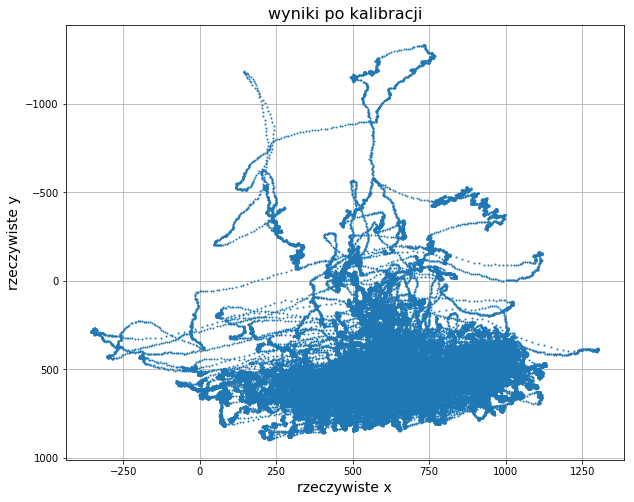

In [18]:
#Wczytanie pliku do kalibrowania (Właściwy plik pomiarowy z przeprowadzonego badania)
fname = 'data/odcinek_15_wojtek.txt'
df = read_file(filename=fname, head=9)

#Kalibracja danych pomiarowych otrzymanych w eksperymencie
df2 = calibrate_file(df, params)

#Wyrysowanie i zapisanie wykresu z danymi pomiarowymi po kalibracji
#Dane pomiarowe mogą być z pewnogo przedziały czasowego badania
fname = 'output/' + fname.split('/')[1]
draw_calibrated(df2, fname, przedzial = [0, -1])

In [19]:
df2.to_csv('odcinek_15_wojtek.txt', sep='\t')

   Eye_X  Eye_Y
0   1571   2295
1   1866   2357
2   1280   2822
3   1737   2854
4   1561   2674


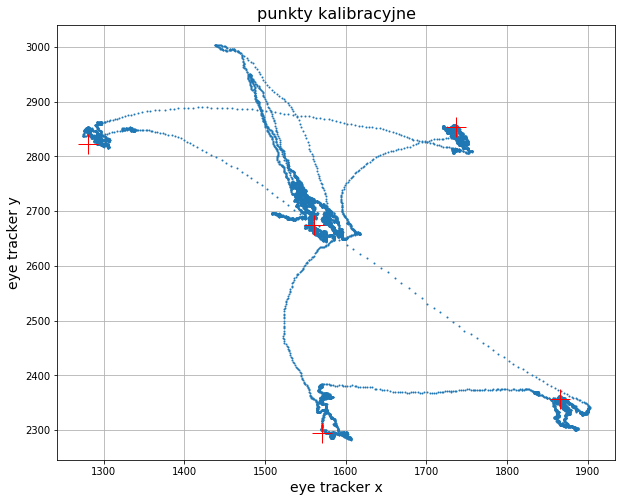

In [31]:
#Wczytanie pliku z danymi do kalibracji
fname = 'data/zofia_hitler_kalib_2.txt'
df = read_file(filename=fname)

#Wyznaczanie punktów do kalibracji
points = calc_points(df, parts=7, first_part=1.9)
plt.rcParams['figure.figsize'] = [10, 8]
print(points)

#Wyrysowanie i zapisanie wykresu z punktami pomiarowymi w czasie przeprowadzania kalibraci
#oraz z zaznoczonymi punktami, które zostaną wykorzystane do kalibracji.
fname = 'output/' + fname.split('/')[1]
draw_calib_points(df, fname)


(3.11939062388081, 1.3129738320847752, -7774.6403230341875, 1.743205694269992, -0.1825079727545387, -3731.671807054161)


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

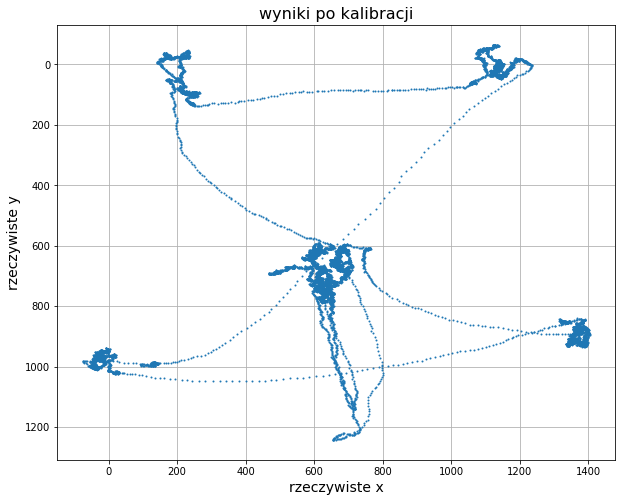

In [21]:
#Obliczanie parametrów funkcji kalibrującej
#oraz iyrysowanie i zapisanie wykresów z dopasowaniem funkcji kalibrującej
fname = 'output/' + fname.split('/')[1]
params = get_calibration_params(points, fname)
print(params)

#Wczytanie pliku do kalibrowania (Właściwy plik pomiarowy z przeprowadzonego badania)
fname = 'data/zofia_hitler_kalib_2.txt'
df = read_file(filename=fname)

#Kalibracja danych pomiarowych otrzymanych w eksperymencie
df2 = calibrate_file(df, params)

#Wyrysowanie i zapisanie wykresu z danymi pomiarowymi po kalibracji
#Dane pomiarowe mogą być z pewnogo przedziały czasowego badania
fname = 'output/' + fname.split('/')[1]
draw_calibrated(df2, fname, przedzial = [0, -1])

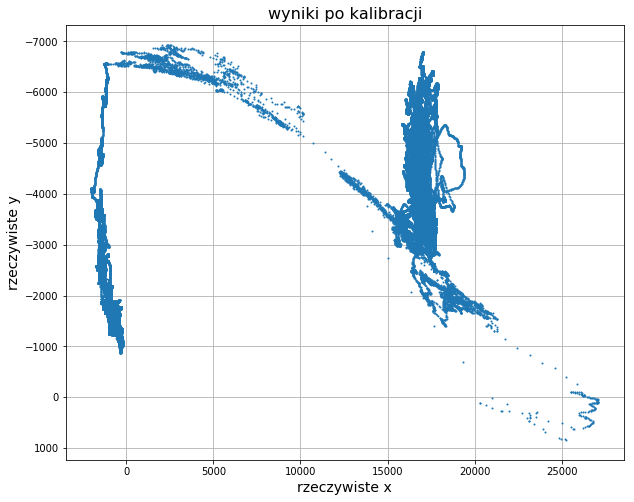

In [22]:
#Wczytanie pliku do kalibrowania (Właściwy plik pomiarowy z przeprowadzonego badania)
fname = 'data/zofia_hitler.txt'
df = read_file(filename=fname)

#Kalibracja danych pomiarowych otrzymanych w eksperymencie
df2 = calibrate_file(df, params)

#Wyrysowanie i zapisanie wykresu z danymi pomiarowymi po kalibracji
#Dane pomiarowe mogą być z pewnogo przedziały czasowego badania
fname = 'output/' + fname.split('/')[1]
draw_calibrated(df2, fname, przedzial = [0, -1])

In [23]:
df2.to_csv('zofia_hitler.txt', sep='\t')

   Eye_X  Eye_Y
0   1338   1830
1   2105   1762
2   1367   1986
3   2126   1888
4   1705   1916


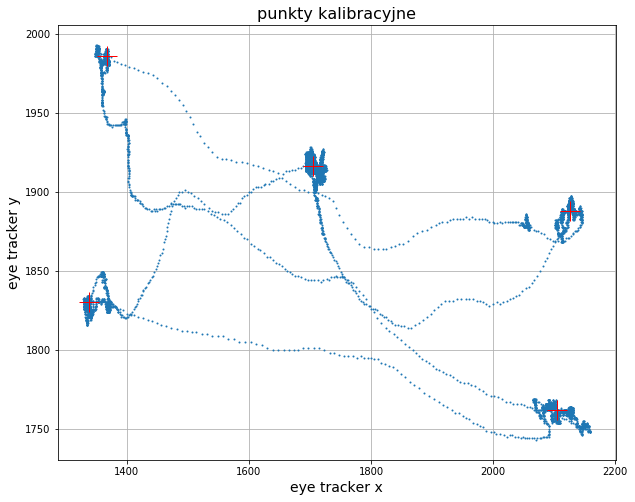

In [32]:
#Wczytanie pliku z danymi do kalibracji
fname = 'data/filip kalib_1.txt'
df = read_file(filename=fname)

#Wyznaczanie punktów do kalibracji
points = calc_points(df, parts=6, first_part=0.9)
plt.rcParams['figure.figsize'] = [10, 8]
print(points)

#Wyrysowanie i zapisanie wykresu z punktami pomiarowymi w czasie przeprowadzania kalibraci
#oraz z zaznoczonymi punktami, które zostaną wykorzystane do kalibracji.
fname = 'output/' + fname.split('/')[1]
draw_calib_points(df, fname)


(1.6538739920985297, -0.1910414476053206, -1859.754860864524, 6.073761956468852, 0.6756277006914337, -12055.626727459849)


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

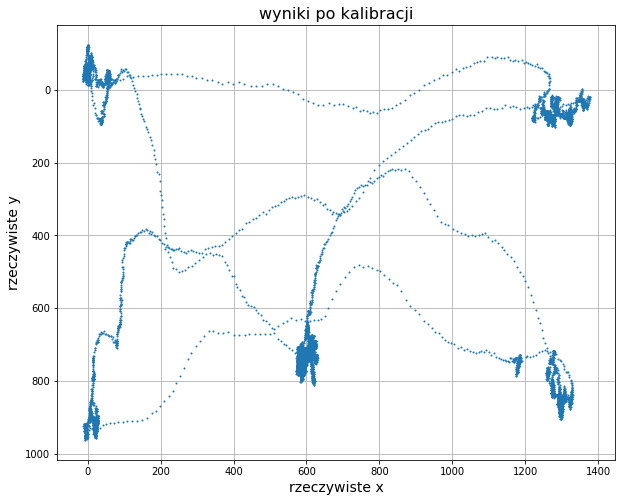

In [25]:
#Obliczanie parametrów funkcji kalibrującej
#oraz iyrysowanie i zapisanie wykresów z dopasowaniem funkcji kalibrującej
fname = 'output/' + fname.split('/')[1]
params = get_calibration_params(points, fname)
print(params)

#Wczytanie pliku do kalibrowania (Właściwy plik pomiarowy z przeprowadzonego badania)
fname = 'data/filip kalib_1.txt'
df = read_file(filename=fname)

#Kalibracja danych pomiarowych otrzymanych w eksperymencie
df2 = calibrate_file(df, params)

#Wyrysowanie i zapisanie wykresu z danymi pomiarowymi po kalibracji
#Dane pomiarowe mogą być z pewnogo przedziały czasowego badania
fname = 'output/' + fname.split('/')[1]
draw_calibrated(df2, fname, przedzial = [0, -1])

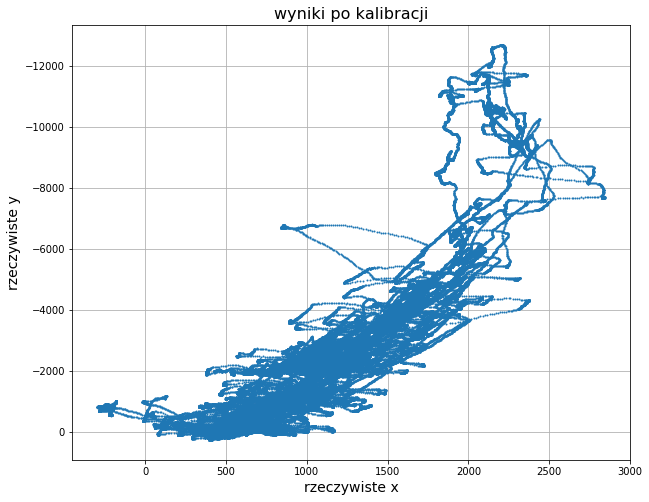

In [26]:
#Wczytanie pliku do kalibrowania (Właściwy plik pomiarowy z przeprowadzonego badania)
fname = 'data/filipfilm.txt'
df = read_file(filename=fname)

#Kalibracja danych pomiarowych otrzymanych w eksperymencie
df2 = calibrate_file(df, params)

#Wyrysowanie i zapisanie wykresu z danymi pomiarowymi po kalibracji
#Dane pomiarowe mogą być z pewnogo przedziały czasowego badania
fname = 'output/' + fname.split('/')[1]
draw_calibrated(df2, fname, przedzial = [0, -1])

In [27]:
df2.to_csv('filip_hitler.txt', sep='\t')